In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# borrowed from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sm = pd.read_json("../data_fetching/json2/SequelMemes.json")
pm = pd.read_json("../data_fetching/json2/PrequelMemes.json")
bof = pd.concat([sm,pm])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
sm_titles = sm[["title"]]
pm_titles = pm[["title"]]

sm_titles["is_sequel_meme"] = 1
pm_titles["is_sequel_meme"] = 0

meme_titles = pd.concat([pm_titles,sm_titles])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [4]:
sm_titles.shape

(14600, 2)

In [5]:
pm_titles.shape

(13250, 2)

In [6]:
import time

def old_new_post(df, df_label):
    # https://stackoverflow.com/a/12400584/2548452
    oldest_post = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.min()['created_utc']))
    newest_post = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.max()['created_utc']))
    print(f"Oldest {df_label} post is {oldest_post}")
    print(f"Newest {df_label} post is {newest_post}")

old_new_post(sm,"r/SequelMemes")
print()
old_new_post(pm,"r/PrequelMemes")
print()
old_new_post(bof,"For both subreddits")

Oldest r/SequelMemes post is 2017-01-14 11:07:40
Newest r/SequelMemes post is 2018-05-04 11:35:41

Oldest r/PrequelMemes post is 2016-12-26 19:29:26
Newest r/PrequelMemes post is 2017-03-14 17:23:44

Oldest For both subreddits post is 2016-12-26 19:29:26
Newest For both subreddits post is 2018-05-04 11:35:41


In [7]:
cvec = CountVectorizer(stop_words="english", ngram_range=(1,3))
corpus = [title[0] for title in meme_titles[["title"]].values]

cvec.fit(corpus)
new_corpus  = cvec.transform(corpus)

new_corpus

<27850x112927 sparse matrix of type '<class 'numpy.int64'>'
	with 239999 stored elements in Compressed Sparse Row format>

In [39]:
# Semi inspired by
# http://sdsawtelle.github.io/blog/output/spam-classification-part2-vectorization-and-svm-pipeline.html
import collections
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

stemmer = SnowballStemmer("english")
english_sw = stopwords.words("english")

def clean_word(word):
    return re.sub(r"([0-9]|\.|')","", word.lower())

def flat_list(df, stop_words, stemming=False):
    if stemming == True:
        corpus = [stemmer.stem(title[0]) for title in df[["title"]].values]
    else:
        corpus = [title[0] for title in df[["title"]].values]
    
    if stop_words == True:
        flatlist = [clean_word(word) for title in corpus for word in title.split(" ") if word not in english_sw]
    else:
        flatlist = [clean_word(word) for title in corpus for word in title.split(" ")]
    return flatlist

def word_counts(df,sub, count, stop_words=False, stemming=False):
    flat_ = flat_list(df, stop_words, stemming)
    counts_dict = collections.Counter(flat_)
    no_blanks = [(x,i) for x,i in counts_dict.most_common(count) if x!='']
    return pd.DataFrame(no_blanks, columns=["word",f"{sub} count"])
    
def get_counts(count, data_frame={}, stop_words=False, stemming=False):
    if "frame" in data_frame.keys():
        return word_counts(
                data_frame["frame"],
                data_frame["title"],
                count, 
                stop_words, 
                stemming).set_index("word")
    else:
        counts = [word_counts(sm,"r/SequelMemes",count, stop_words, stemming), 
                  word_counts(pm,"r/PrequelMemes",count, stop_words,stemming)]
        # https://stackoverflow.com/questions/23668427/pandas-joining-multiple-dataframes-on-columns
        counts_df = reduce(lambda left,right: pd.merge(left, right, on="word"), counts)
        return counts_df.set_index("word")

def plot_counts(count, data_frame={}, stop_words=False, stemming=False):
    top_whatever = get_counts(count, data_frame, stop_words, stemming)
    ax = top_whatever.plot(kind="barh", figsize=(20,10), fontsize=20)
    ax.legend(fontsize=20)
    ax.yaxis.label.set_visible(False)
    stemming = '; words are stemmed' if stemming == True else '; words are NOT stemmed'
    title_frag = f' (no stop words{stemming})' if stop_words == False else f' (with stop words{stemming})'
    ax.set_title(f"Frequency count of top {len(top_whatever)} words{title_frag}",
                 fontsize=25, 
                 pad=50)
    if "frame" in data_frame.keys():
        plt.savefig(f"../presentation/images/Frequency count of top {len(top_whatever)} words{title_frag} - {data_frame['title'].replace('r/','')}.png")
    else:
        plt.savefig(f"../presentation/images/Frequency count of top {len(top_whatever)} words{title_frag}.png")
    print()


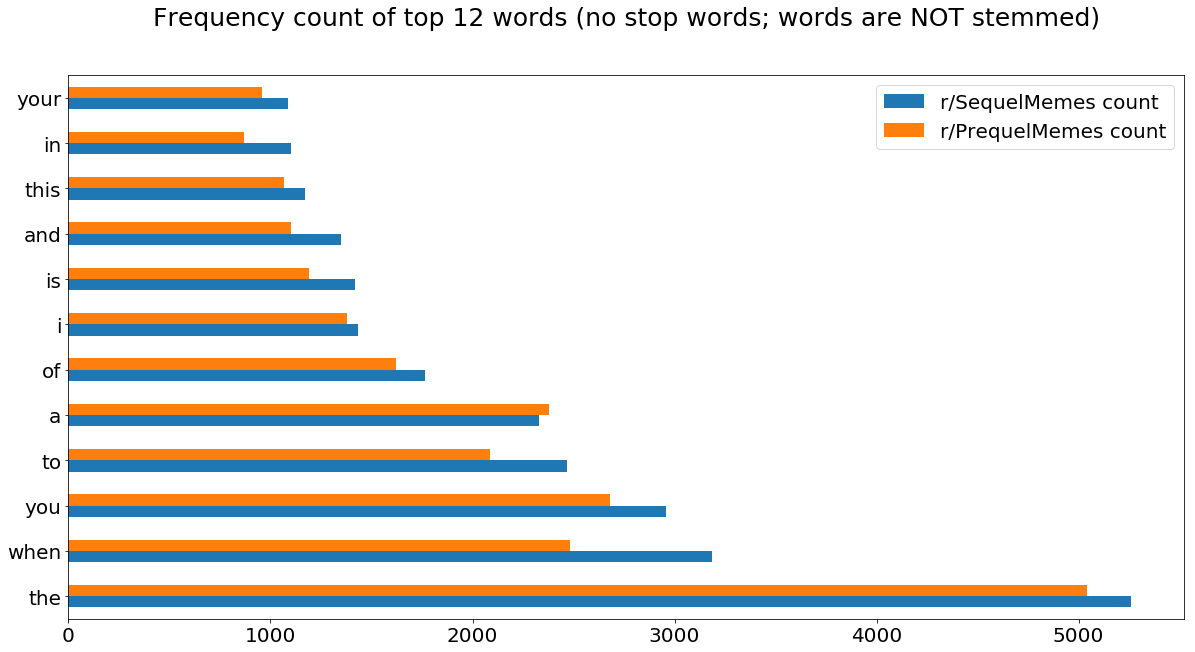

In [30]:
plot_counts(12)

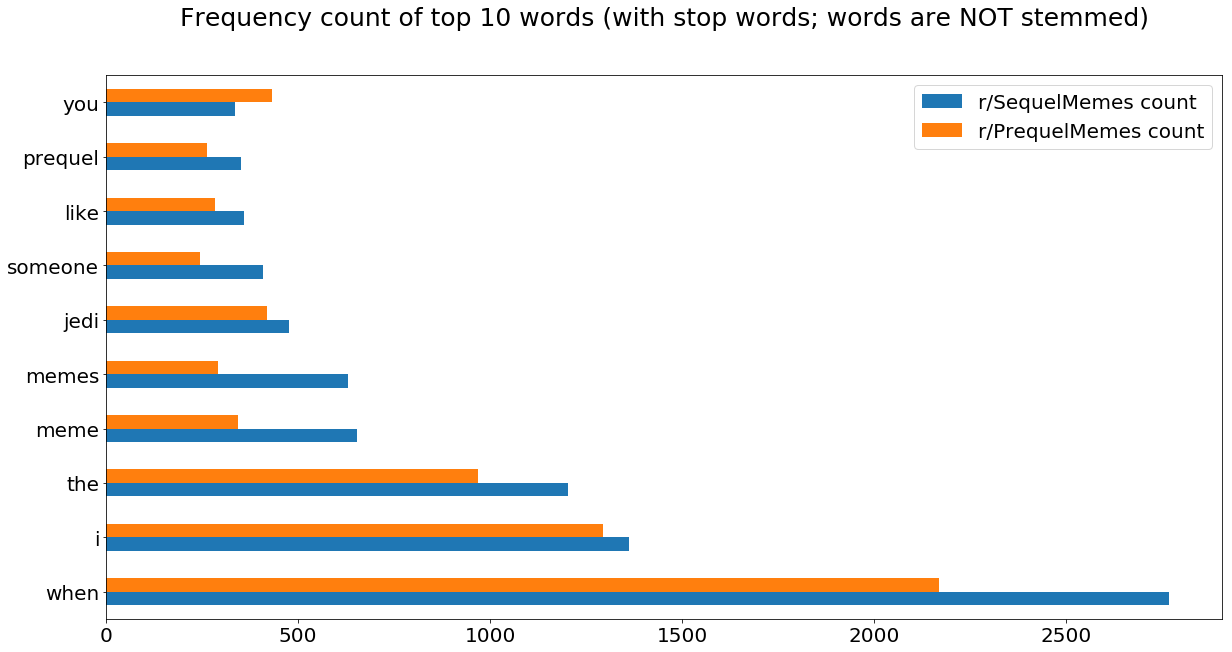

In [31]:
plot_counts(21, stop_words=True)

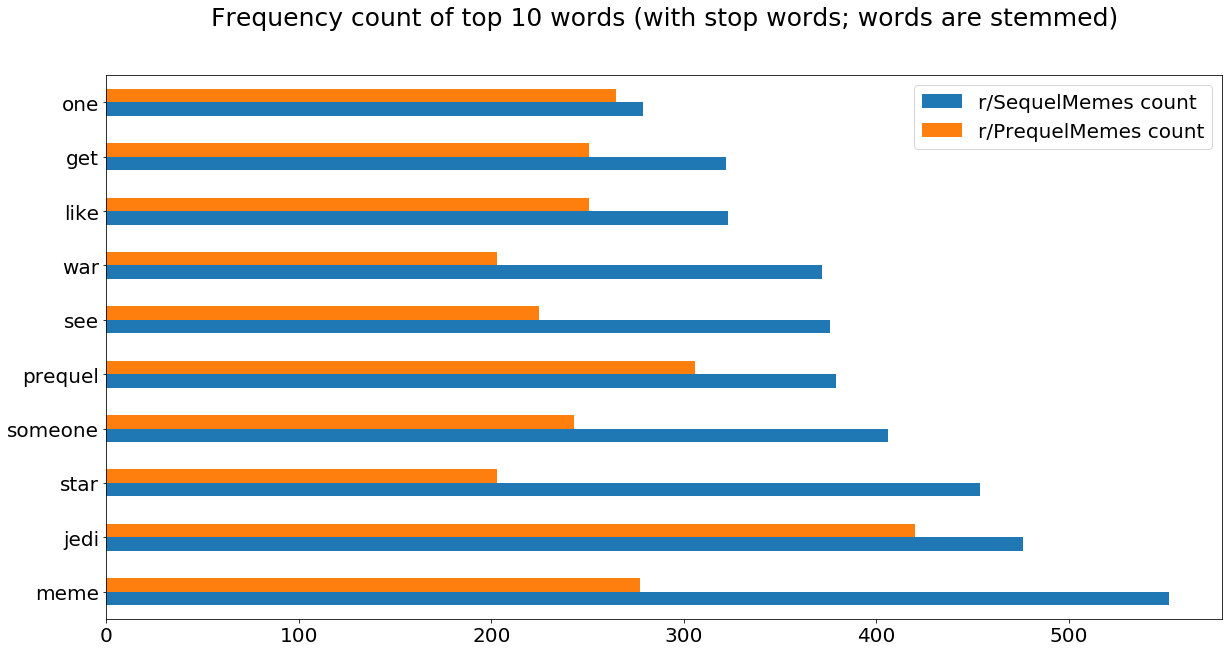

In [32]:
plot_counts(22, stop_words=True, stemming=True)

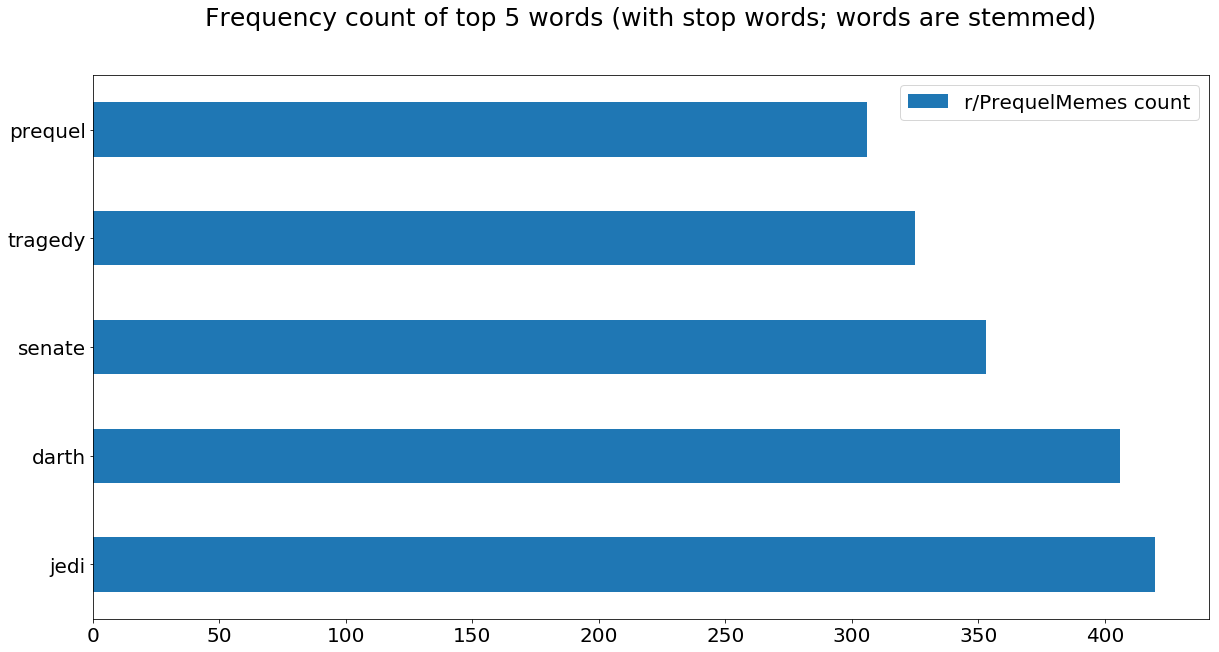

In [40]:
plot_counts(6, 
            data_frame={
                "frame":pm[['title']],
                "title":"r/PrequelMemes"
            }, stop_words=True, stemming=True)

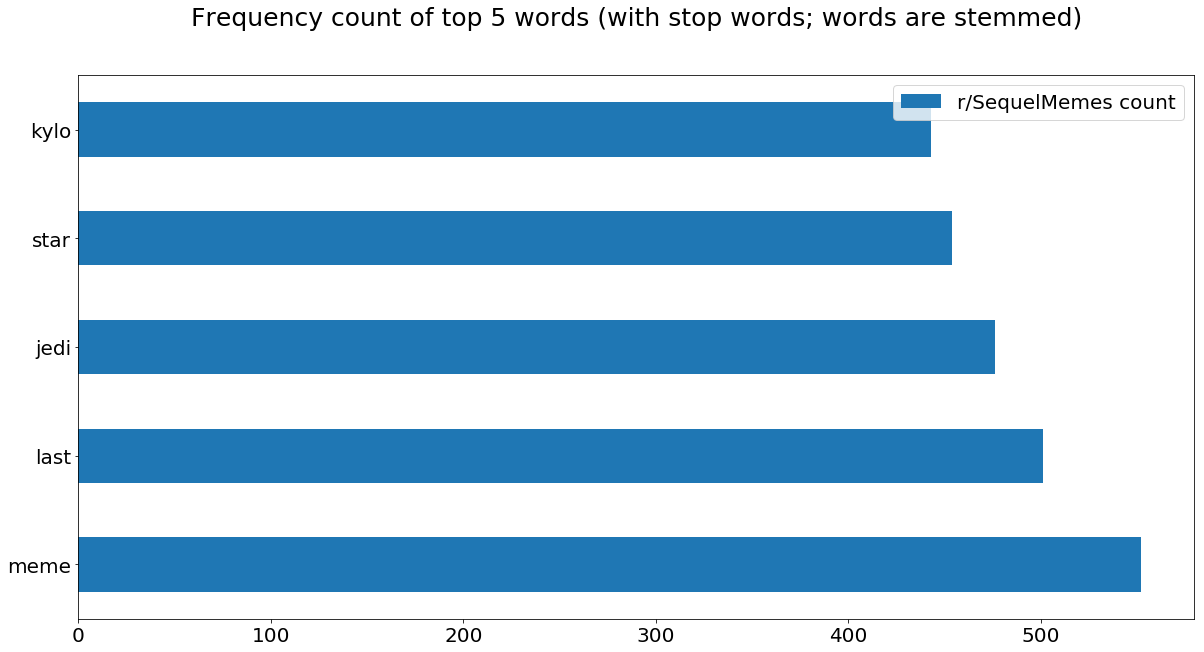

In [41]:
plot_counts(6, 
            data_frame={
                "frame":sm[['title']],
                "title":"r/SequelMemes"
            }, stop_words=True, stemming=True)

In [14]:
# # https://stackoverflow.com/a/13431956/2548452

# def title_ngrams(df):
#     longer_titles = [title for title in df[['title']].values.tolist() if len(title[0].split(" ")) > 2]
#     tb_trigrams = []
#     for title in longer_titles:
#         tt = nltk.word_tokenize(title[0])
#         tb_trigrams.append(list(nltk.trigrams(tt)))
#     return tb_trigrams

In [15]:
# pipe = {
#     "cvec"
# }

# gs = GridSearchCV()

# cvec = CountVectorizer(stop_words="english", analyzer=lambda x:x, max_df=.25)
# for meme_sb in [sm, pm]:
#     cvec.fit_transform(title_ngrams(meme_sb))